In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/train.csv', index_col=0)

In [3]:
print(df.columns)
print(df.shape)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(891, 11)


In [4]:
df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S
122,0,3,"Moore, Mr. Leonard Charles",male,NaN,0,0,A4. 54510,8.050,NaN,S
21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.000,NaN,S
87,0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.375,NaN,S
634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.000,NaN,S


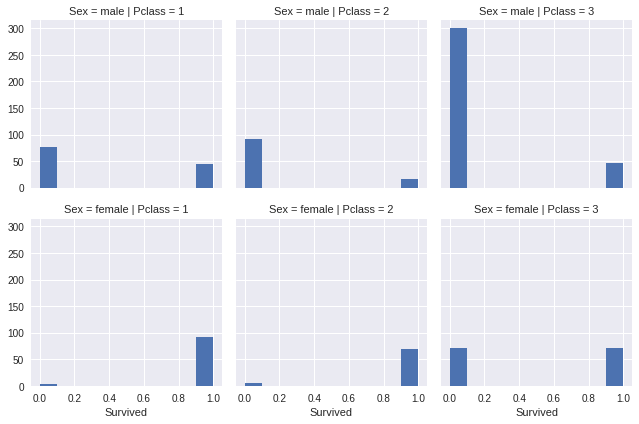

In [5]:
grid = sns.FacetGrid(data=df, row='Sex', col='Pclass')

_ = grid.map(plt.hist, "Survived")

In [6]:
discrete_features = ['Pclass', 'Sex', 'SibSp','Parch']

survivals = []

for feature in discrete_features:
    groups = df.copy().groupby(feature)
       
    survival_per_level = groups['Survived'].mean()
    
    survivals.append(survival_per_level)

In [7]:
survivals

[Pclass
 1    0.629630
 2    0.472826
 3    0.242363
 Name: Survived, dtype: float64, Sex
 female    0.742038
 male      0.188908
 Name: Survived, dtype: float64, SibSp
 0    0.345395
 1    0.535885
 2    0.464286
 3    0.250000
 4    0.166667
 5    0.000000
 8    0.000000
 Name: Survived, dtype: float64, Parch
 0    0.343658
 1    0.550847
 2    0.500000
 3    0.600000
 4    0.000000
 5    0.200000
 6    0.000000
 Name: Survived, dtype: float64]

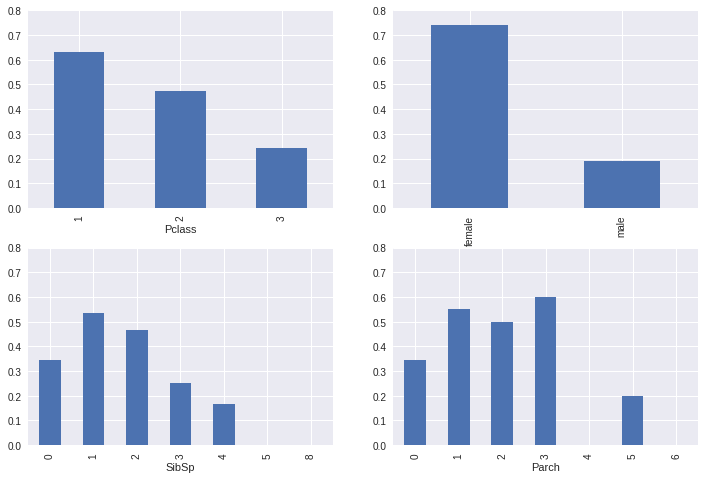

In [8]:
f, axes = plt.subplots(2,2)
f.set_size_inches(12,8)

for i, survival in enumerate(survivals):
    current_axis = axes[int(i/2)][i%2]
    survival.plot(kind='bar', ax=current_axis)
    current_axis.set_ylim(0,0.8)

(0, 200)

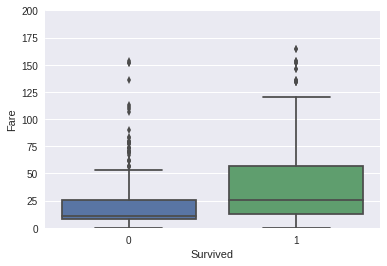

In [9]:
sns.boxplot(data=df, y='Fare', x='Survived')
plt.gca().set_ylim(0,200)

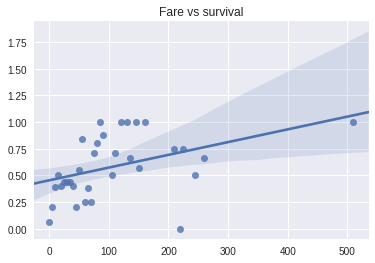

In [10]:
# Group by fare bins
fare_groups = df.groupby(by=lambda row: int(df.ix[row]['Fare'] / 5))
survival_per_fare = fare_groups['Survived'].mean()

sns.regplot(survival_per_fare.index.values * 5, survival_per_fare.values)
_ = plt.gca().set_title('Fare vs survival')

## Feature engineering:

* Sex has to be encoded into 0/1
* Pclass will remain as is
* Fare as is
* SibSp and Parch - examine interaction. Combine them?
* Interaction terms: use [this preprocessor](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)